In [80]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
import math

In [6]:
df = pd.read_csv("monthly_milk.csv")
df.head()

,month,milk_prod_per_cow_kg
0,1962-01-01,265.05
1,1962-02-01,252.45
2,1962-03-01,288.00
3,1962-04-01,295.20
4,1962-05-01,327.15


In [12]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.milk_prod_per_cow_kg.dropna())
print('ADF Statistics %f' %result[0])
print('p-value %f' %result[1])

ADF Statistics -1.303812
p-value 0.627427


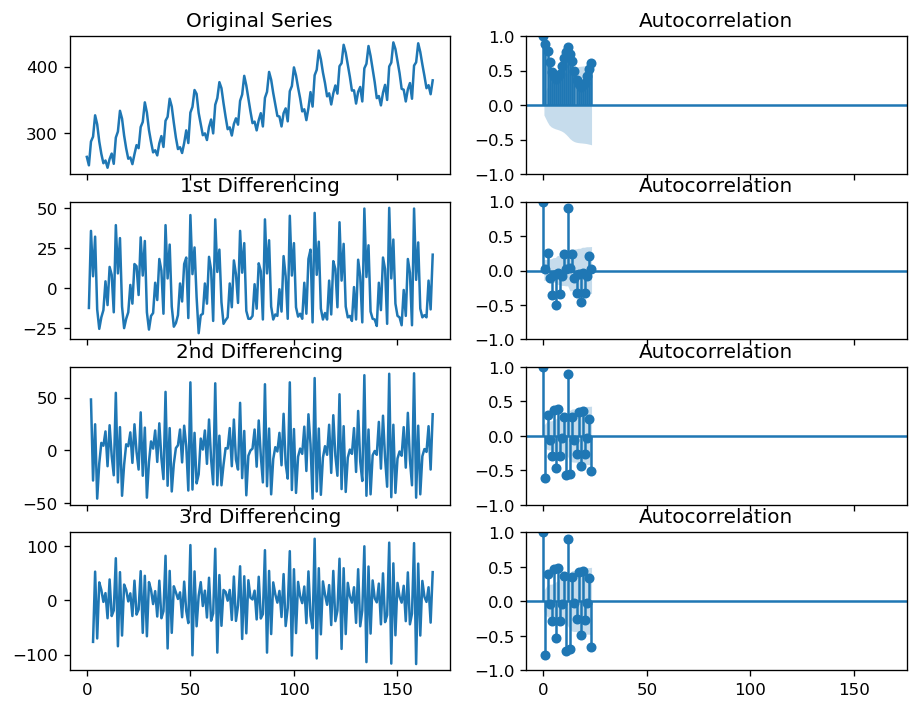

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


fig, axes = plt.subplots(4, 2, sharex=True)
axes[0,0].plot(df.milk_prod_per_cow_kg);axes[0,0].set_title("Original Series")
plot_acf(df.milk_prod_per_cow_kg, ax=axes[0,1])

axes[1,0].plot(df.milk_prod_per_cow_kg.diff());axes[1,0].set_title("1st Differencing")
plot_acf(df.milk_prod_per_cow_kg.diff().dropna(), ax =axes[1,1])

# axes[2,0].plot(df.milk_prod_per_cow_kg.diff().diff());axes[2,0].set_title("2nd Differencing")
# plot_acf(df.milk_prod_per_cow_kg.diff().diff().dropna(), ax=axes[2,1])

# axes[3,0].plot(df.milk_prod_per_cow_kg.diff().diff().diff());axes[3,0].set_title("3rd Differencing")
# plot_acf(df.milk_prod_per_cow_kg.diff().diff().diff().dropna(), ax=axes[3,1])

# axes[4,0].plot(df.milk_prod_per_cow_kg.diff().diff().diff().diff());axes[4,0].set_title("4th Differencing")
# plot_acf(df.milk_prod_per_cow_kg.diff().diff().diff().diff().dropna(), ax=axes[4,1])

plt.show()

c:\Users\vidhi\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


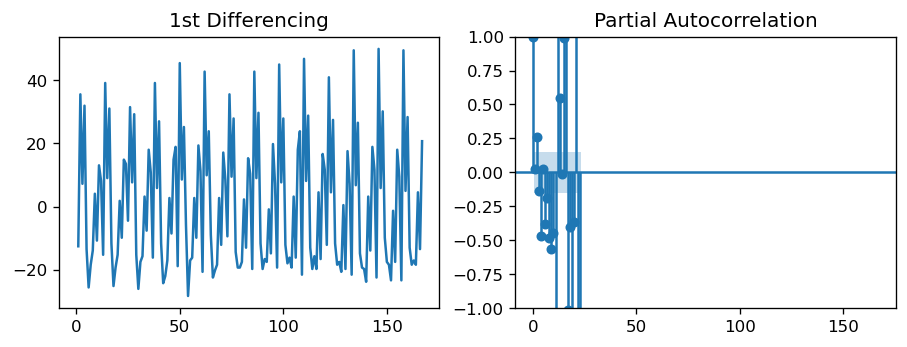

In [36]:
plt.rcParams.update({'figure.figsize':(9,3),'figure.dpi':120})

fig, axes=plt.subplots(1,2,sharex=True)
axes[0].plot(df.milk_prod_per_cow_kg.diff()); axes[0].set_title("1st Differencing")
axes[1].set(ylim=(0,5))
plot_pacf(df.milk_prod_per_cow_kg.diff().dropna(), ax=axes[1])
plt.show()

We can see that the PACF lag 1 is quite significant since it is well above the significance line. So, we will fix the value of p as 1.

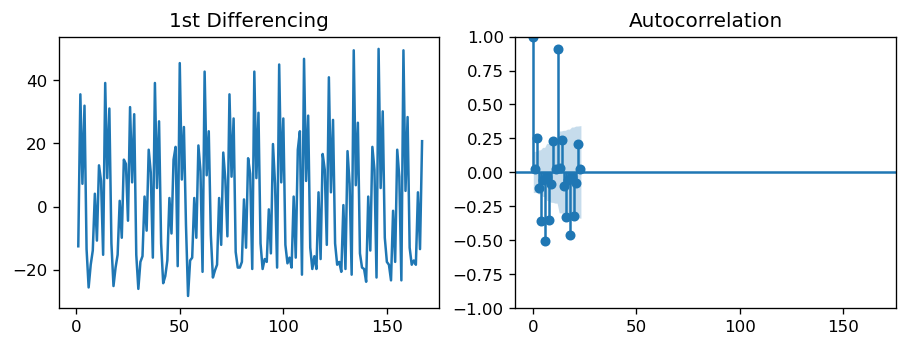

In [37]:
fig, axes=plt.subplots(1,2,sharex=True)
axes[0].plot(df.milk_prod_per_cow_kg.diff()); axes[0].set_title("1st Differencing")
axes[1].set(ylim=(0,1.2))
plot_acf(df.milk_prod_per_cow_kg.diff().dropna(), ax=axes[1])
plt.show()

We fix q as 1 because we see couple of lags well above the significance line.

In [62]:
# 1,1,1 ARIMA model
model = ARIMA(df.milk_prod_per_cow_kg, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     milk_prod_per_cow_kg   No. Observations:                  168
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -740.159
Date:                  Mon, 07 Nov 2022   AIC                           1486.318
Time:                          16:00:40   BIC                           1495.672
Sample:                               0   HQIC                          1490.115
                                  - 168                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5094      0.889     -0.573      0.567      -2.252       1.233
ma.L1          0.4527      0.940      0.481      0.630      -1.391       2.296
sigma2       414.1786     71.854    

In [63]:
model = ARIMA(df.milk_prod_per_cow_kg, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     milk_prod_per_cow_kg   No. Observations:                  168
Model:                   ARIMA(1, 1, 0)   Log Likelihood                -740.469
Date:                  Mon, 07 Nov 2022   AIC                           1484.938
Time:                          16:00:44   BIC                           1491.174
Sample:                               0   HQIC                          1487.469
                                  - 168                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0236      0.114      0.208      0.836      -0.199       0.247
sigma2       415.7163     63.947      6.501      0.000     290.383     541.050
Ljung-Box (L1) (Q):                 

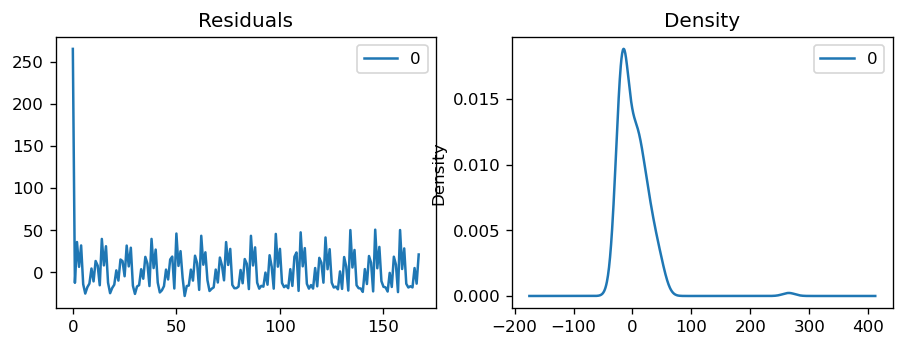

In [64]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

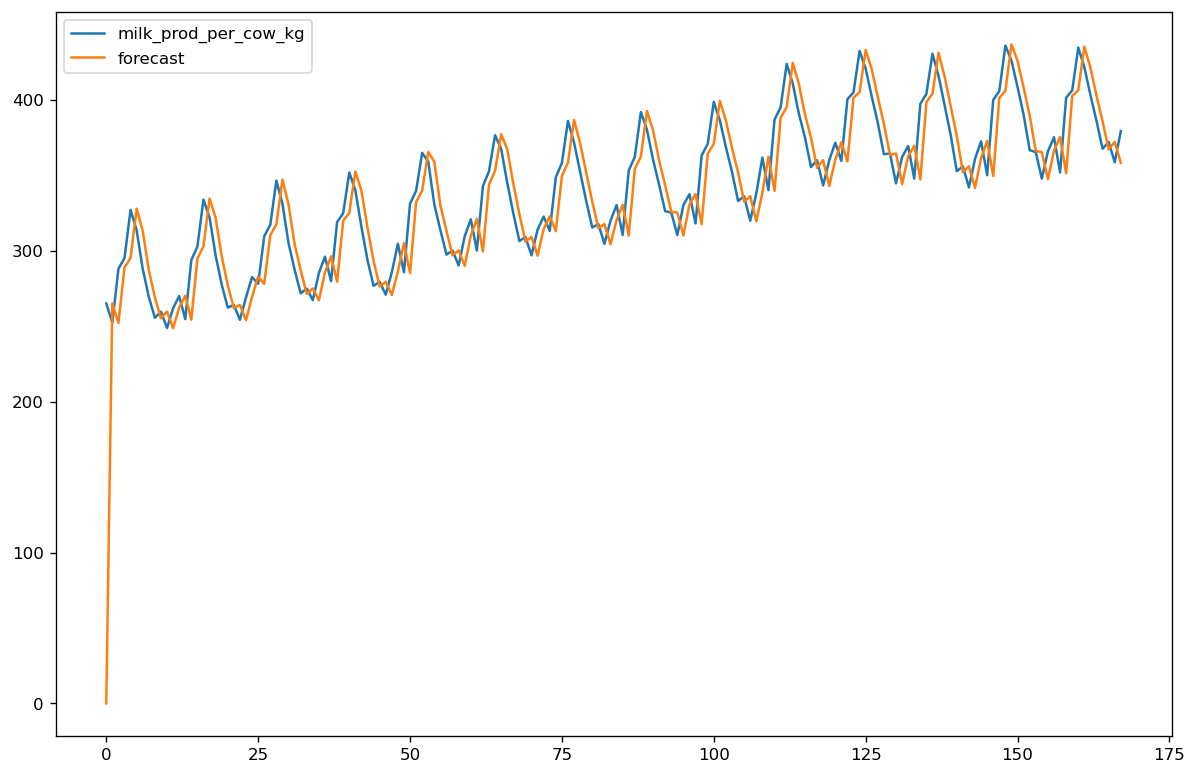

In [78]:
df['forecast'] = model_fit.predict(dynamic= False)  
df[['milk_prod_per_cow_kg', 'forecast']].plot(figsize=(12, 8))
plt.show()

Finding optimal ARIMA model using Out-Of-Time Validation

In [87]:
total_size = len(df)
train_size = math.floor(0.8*total_size)
train = df.head(train_size)
test = df.tail(len(df)-train_size)

168


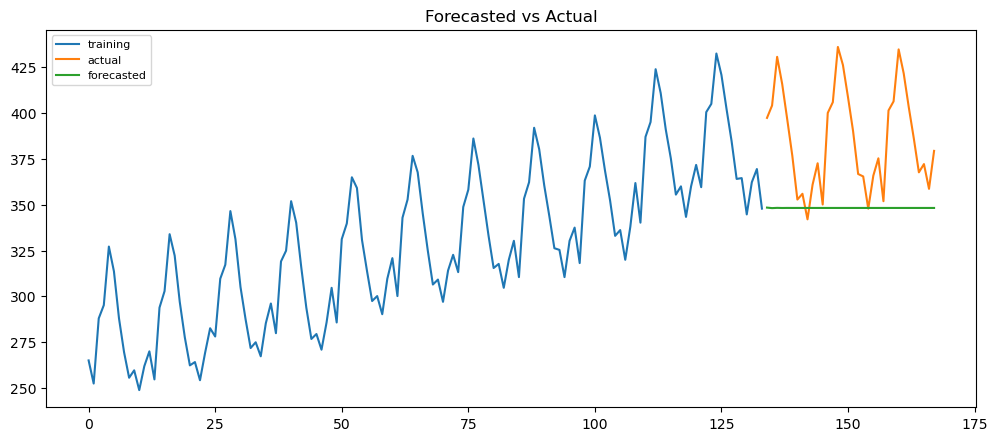

In [113]:
model = ARIMA(train.milk_prod_per_cow_kg, order=(1,1,1))
fitted = model.fit()

fc = fitted.forecast(168, alpha=0.05)

fc_Series = pd.Series(conf, index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.milk_prod_per_cow_kg, label='training')
plt.plot(test.milk_prod_per_cow_kg, label='actual')
plt.plot(fc_Series, label='forecasted')
plt.title('Forecasted vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()